# Untangling Counties Ver 3

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import colorlover as cl
colors = [[i / 255 for i in j] for j in cl.to_numeric(cl.scales['5']['qual']['Dark2'])]

### Functions

In [2]:
def ny_scatter2(ax, df, coord_col_name = "test_{}_rank"):
    # fig, ax = plt.subplots(figsize = (s, s))
    for ind, county in enumerate(df.county_name.unique()):
        county_df = df[df.county_name == county]
        ax.scatter(
            y = county_df[coord_col_name.format("lat")],
            x = county_df[coord_col_name.format("lng")],
            s = county_df.sqrt_mult,
            marker = "s",
            label = county,
            alpha = 0.7,
            color = colors[ind % 5],
            edgecolor = "none")
    # ax.legend(loc = 9, bbox_to_anchor = (0.5,0))
    # return fig
    
def get_min_max(df, center_col_name = "prop_scaled_{}_rank", side_col_name = "sqrt_mult"):
    for si, i in enumerate(["min", "max"]):
        for j in ["lat", "lng"]:
            df[("{}_" + center_col_name).format(i, j)] = (
                df[center_col_name.format(j)] + (2 * si - 1) *
                (df[side_col_name] / 2))
    return df

def normalize(df, col_names, min_col_name, max_col_name):
    for c in col_names:
        df["norm_" + c] = (df[c] - df[min_col_name].min()) / (df[max_col_name].max() - df[min_col_name].min())
    return df

### Read in data

In [3]:
county_shapes = pd.read_csv("./ny_county_shapes.csv").set_index("county_name")
ny_map_county_squares = pd.read_csv("./ny_map_county_squares.csv")

In [4]:
ny_map_county_squares.head()

,county_name,lat,lng,state,lng_rank,lat_rank,nyc,min_lng_rank,min_lat_rank,max_lng_rank,...,ttl,pre_mult,mult,sqrt_mult,mid_lng_rank,mid_lat_rank,scaled_lng_rank,scaled_lat_rank,test_lat_rank,test_lng_rank
0,Montgomery,42.920886,-74.476076,NY,54.0,43.0,False,52.0,41.0,57.0,...,1522,72.476190,27.296228,5.224579,54.5,42.5,51.387710,45.612290,12820.304341,16099.917080
1,Chautauqua,42.162278,-79.666456,NY,3.0,30.0,False,3.0,28.0,8.0,...,4765,108.295455,40.786600,6.386439,5.5,32.0,-12.966097,17.227123,8944.398378,894.439838
2,Rensselaer,42.862532,-73.661899,NY,62.0,42.0,False,61.0,36.0,65.0,...,7983,249.468750,93.955763,9.693078,63.0,39.5,52.306922,66.232695,12522.157729,18485.089980
3,St Lawrence,44.379747,-75.392025,NY,45.0,68.0,False,41.0,63.0,53.0,...,3837,27.804348,10.471767,3.236011,47.0,70.5,38.527978,59.909972,20273.969656,13416.597566
4,Delaware,41.987215,-74.984937,NY,49.0,27.0,False,45.0,25.0,54.0,...,1949,27.842857,10.486271,3.238251,49.5,30.0,47.380874,17.285246,8049.958540,14609.184017


In [5]:
ny_map_county_squares.lng_rank.max(), ny_map_county_squares.lng_rank.min()

(79.0, 3.0)

In [6]:
ny_map_county_squares.lat_rank.max(), ny_map_county_squares.lat_rank.min()

(78.0, 2.0)

In [53]:
lat_max_sqrt_mult = ny_map_county_squares.groupby(["lat_rank"], as_index = False)["sqrt_mult"].max().sort_values("lat_rank")
lng_max_sqrt_mult = ny_map_county_squares.groupby(["lng_rank"], as_index = False)["sqrt_mult"].max().sort_values("lng_rank")

In [54]:
max_sqrt_mult = ny_map_county_squares.sqrt_mult.max()

In [55]:
max_sqrt_mult

298.146612587503

In [56]:
lat_max_sqrt_mult["next_lat"] = lat_max_sqrt_mult.lat_rank + 1
lat_max_sqrt_mult = lat_max_sqrt_mult.merge(right = lat_max_sqrt_mult, left_on = ["lat_rank"], right_on = ["next_lat"], how = "left").fillna(0)

lng_max_sqrt_mult["next_lng"] = lng_max_sqrt_mult.lng_rank + 1
lng_max_sqrt_mult = lng_max_sqrt_mult.merge(right = lng_max_sqrt_mult, left_on = ["lng_rank"], right_on = ["next_lng"], how = "left").fillna(0)

In [57]:
lat_max_sqrt_mult.head()

,lat_rank_x,sqrt_mult_x,next_lat_x,lat_rank_y,sqrt_mult_y,next_lat_y
0,2.0,56.968093,3.0,0.0,0.000000,0.0
1,3.0,166.988325,4.0,2.0,56.968093,3.0
2,4.0,166.988325,5.0,3.0,166.988325,4.0
3,5.0,166.988325,6.0,4.0,166.988325,5.0
4,6.0,298.146613,7.0,5.0,166.988325,6.0


In [58]:
lat_max_sqrt_mult["lat_adjust"] = max_sqrt_mult - (lat_max_sqrt_mult["sqrt_mult_x"] + lat_max_sqrt_mult["sqrt_mult_y"]) / 2
lng_max_sqrt_mult["lng_adjust"] = max_sqrt_mult - (lng_max_sqrt_mult["sqrt_mult_x"] + lng_max_sqrt_mult["sqrt_mult_y"]) / 2

In [59]:
lat_max_sqrt_mult["cum_lat_adjust"] = lat_max_sqrt_mult.lat_adjust.cumsum()
lng_max_sqrt_mult["cum_lng_adjust"] = lng_max_sqrt_mult.lng_adjust.cumsum()

In [60]:
lat_max_sqrt_mult.head()

,lat_rank_x,sqrt_mult_x,next_lat_x,lat_rank_y,sqrt_mult_y,next_lat_y,lat_adjust,cum_lat_adjust
0,2.0,56.968093,3.0,0.0,0.000000,0.0,269.662566,269.662566
1,3.0,166.988325,4.0,2.0,56.968093,3.0,186.168404,455.830970
2,4.0,166.988325,5.0,3.0,166.988325,4.0,131.158288,586.989257
3,5.0,166.988325,6.0,4.0,166.988325,5.0,131.158288,718.147545
4,6.0,298.146613,7.0,5.0,166.988325,6.0,65.579144,783.726689


In [61]:
ny_map_county_squares_w_adjust = ny_map_county_squares.merge(
    right = lat_max_sqrt_mult[["lat_rank_x", "cum_lat_adjust"]],
    left_on = "lat_rank",
    right_on = "lat_rank_x",
    how = "left").merge(
    right = lng_max_sqrt_mult[["lng_rank_x", "cum_lng_adjust"]],
    left_on = "lng_rank",
    right_on = "lng_rank_x",
    how = "left")

In [62]:
for i in ["lat", "lng"]:
    ny_map_county_squares_w_adjust["new_test_{}_rank".format(i)] = (
        ny_map_county_squares_w_adjust["test_{}_rank".format(i)] - ny_map_county_squares_w_adjust["cum_{}_adjust".format(i)])

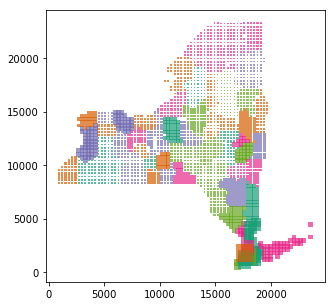

In [63]:
fig, ax = plt.subplots(figsize = (5, 5))
ny_scatter2(ax, ny_map_county_squares_w_adjust)

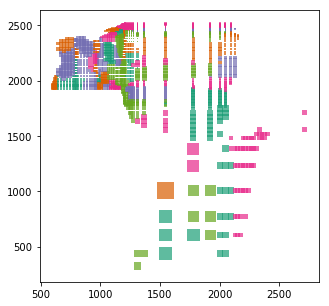

In [64]:
fig, ax = plt.subplots(figsize = (5, 5))
ny_scatter2(ax, ny_map_county_squares_w_adjust, coord_col_name = "new_test_{}_rank")

In [65]:
ny_map_county_squares_w_adjust = get_min_max(ny_map_county_squares_w_adjust, center_col_name = "new_test_{}_rank")

In [66]:
norm_cols = ([{
    "col_names": ["{}_rank".format(i)],
    "min_col_name": "{}_rank".format(i),
    "max_col_name": "{}_rank".format(i)} for i in ["lat", "lng"]] + 
    [{
    "col_names": ["{}new_test_{}_rank".format(j, i) for j in ["", "min_", "max_"]],
    "min_col_name": "min_new_test_{}_rank".format(i),
    "max_col_name": "max_new_test_{}_rank".format(i)} for i in ["lat", "lng"]])

for i in norm_cols:
    ny_map_county_squares_w_adjust = normalize(ny_map_county_squares_w_adjust, col_names = i["col_names"], min_col_name = i["min_col_name"], max_col_name = i["max_col_name"])

In [67]:
ny_map_county_squares_w_adjust.columns

Index(['county_name', 'lat', 'lng', 'state', 'lng_rank', 'lat_rank', 'nyc',
       'min_lng_rank', 'min_lat_rank', 'max_lng_rank', 'max_lat_rank',
       'num_squares', 'county', 'ttl', 'pre_mult', 'mult', 'sqrt_mult',
       'mid_lng_rank', 'mid_lat_rank', 'scaled_lng_rank', 'scaled_lat_rank',
       'test_lat_rank', 'test_lng_rank', 'lat_rank_x', 'cum_lat_adjust',
       'lng_rank_x', 'cum_lng_adjust', 'new_test_lat_rank',
       'new_test_lng_rank', 'min_new_test_lat_rank', 'min_new_test_lng_rank',
       'max_new_test_lat_rank', 'max_new_test_lng_rank', 'norm_lat_rank',
       'norm_lng_rank', 'norm_new_test_lat_rank', 'norm_min_new_test_lat_rank',
       'norm_max_new_test_lat_rank', 'norm_new_test_lng_rank',
       'norm_min_new_test_lng_rank', 'norm_max_new_test_lng_rank'],
      dtype='object')

In [68]:
counties = ny_map_county_squares_w_adjust[["county"]].drop_duplicates().reset_index()
counties["county_id"] = counties.index

In [69]:
ny_map_county_squares_w_adjust = ny_map_county_squares_w_adjust.merge(right = counties[["county", "county_id"]], on = ["county"], how = "left")

In [70]:
norm_col_names = ["norm_" + i for j in [i["col_names"] for i in norm_cols] for i in j]

In [71]:
ny_map_county_squares_w_adjust["square_id"] = ny_map_county_squares_w_adjust.index

In [72]:
ny_map_county_squares_w_adjust[["square_id", "county", "county_id"] + norm_col_names].to_json(
    "./untangled_norm_county_squares_ver2.json", orient = "records")

In [73]:
ny_map_county_squares_w_adjust[ny_map_county_squares_w_adjust.county.isin(["New York", "Bronx"])]

,county_name,lat,lng,state,lng_rank,lat_rank,nyc,min_lng_rank,min_lat_rank,max_lng_rank,...,norm_lat_rank,norm_lng_rank,norm_new_test_lat_rank,norm_min_new_test_lat_rank,norm_max_new_test_lat_rank,norm_new_test_lng_rank,norm_min_new_test_lng_rank,norm_max_new_test_lng_rank,county_id,square_id
444,Bronx,40.878481,-73.865443,NY,60.0,8.0,True,60.0,7.0,60.0,...,0.078947,0.750000,0.489130,0.454480,0.52378,0.556725,0.520479,0.592970,58,444
1070,New York,40.761772,-73.967215,NY,59.0,6.0,True,59.0,6.0,59.0,...,0.052632,0.736842,0.318107,0.251033,0.38518,0.447267,0.377106,0.517428,61,1070
1547,Bronx,40.820127,-73.865443,NY,60.0,7.0,True,60.0,7.0,60.0,...,0.065789,0.750000,0.419830,0.385180,0.45448,0.556725,0.520479,0.592970,58,1547


In [48]:
lng_max_sqrt_mult[lng_max_sqrt_mult.lng_rank_x.between(58, 61)]

,lng_rank_x,sqrt_mult_x,prev_lng_x,lng_rank_y,sqrt_mult_y,prev_lng_y,lng_adjust,cum_lng_adjust
55,58.0,56.968093,57.0,59.0,298.146613,58.0,120.589260,15749.079691
56,59.0,298.146613,58.0,60.0,166.988325,59.0,65.579144,15814.658834
57,60.0,166.988325,59.0,61.0,117.405447,60.0,155.949727,15970.608561
58,61.0,117.405447,60.0,62.0,45.806947,61.0,216.540415,16187.148976


In [34]:
get_min_max(ny_map_county_squares_w_adjust[ny_map_county_squares_w_adjust.county.isin(["New York", "Bronx"])][[
    "county",
    "sqrt_mult",
    "lng_rank",
    "lat_rank",
    "test_lng_rank",
    "test_lat_rank",
    "cum_lat_adjust"
]], "test_{}_rank")

,county,sqrt_mult,lng_rank,lat_rank,test_lng_rank,test_lat_rank,cum_lat_adjust,min_test_lat_rank,min_test_lng_rank,max_test_lat_rank,max_test_lng_rank
444,Bronx,154.023147,60.0,8.0,17888.796755,2385.172901,922.900313,2308.161327,17811.785182,2462.184474,17965.808329
1070,New York,298.146613,59.0,6.0,17590.650143,1788.879676,634.653383,1639.806369,17441.576836,1937.952982,17739.723449
1547,Bronx,154.023147,60.0,7.0,17888.796755,2087.026288,778.776848,2010.014715,17811.785182,2164.037862,17965.808329
